In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [24]:
def calculate_highest_mean_explain(df, metric):
    grouped = df.groupby(['num_cnns', 'batch', 'lr']).agg(mean_metric=(metric, 'mean')).reset_index()
    return grouped.groupby('num_cnns')['mean_metric'].max()

# Function to calculate the highest mean r2_r for dataframes without num_cnns
def calculate_highest_mean_others(df, metric):
    grouped = df.groupby(['batch', 'lr']).agg(mean_metric=(metric, 'mean')).reset_index()
    return grouped['mean_metric'].max()

# Function to find the best combination of 'batch' and 'lr' for each 'num_cnns'
def find_best_combinations(df, metric):
    best_combinations = []
    for num_cnn in df['num_cnns'].unique():
        subset = df[df['num_cnns'] == num_cnn]
        subset = subset[subset[metric] > 0]  # Removing negative values
        if not subset.empty:
            best_comb = subset.loc[subset[metric].idxmax()][['batch', 'lr']]
            best_combinations.append((num_cnn, best_comb['batch'], best_comb['lr']))
    
    # Sort the best combinations by 'num_cnn' in ascending order
    best_combinations.sort(key=lambda x: x[0])
    
    return best_combinations

# Function to calculate mean and variance for the best combinations
def calculate_mean_variance(df, metric, best_combinations):
    mean_values = []
    variance_values = []
    for num_cnn, batch, lr in best_combinations:
        subset = df[(df['num_cnns'] == num_cnn) & (df['batch'] == batch) & (df['lr'] == lr)]
        mean_values.append(subset[metric].mean())
        variance_values.append(subset[metric].var())
    return mean_values, variance_values

def visualize_performance(convnet_metric_path, danq_metric_path, starr_metric_path, explainn_metric_path, label, xlim, r2_ylim, pearson_ylim):
    df_conv = pd.read_csv(convnet_metric_path)
    df_dan = pd.read_csv(danq_metric_path)
    df_starr = pd.read_csv(starr_metric_path)
    df_explain = pd.read_csv(explainn_metric_path)

    # Apply the function to calculate the highest mean r2_r for each num_cnns
    df_explain_r2_highest = calculate_highest_mean_explain(df_explain,'r2_r')
    max_r2_conv = calculate_highest_mean_others(df_conv,'r2_r')
    max_r2_dan = calculate_highest_mean_others(df_dan,'r2_r')
    max_r2_starr = calculate_highest_mean_others(df_starr,'r2_r')

    # Apply the function to calculate the highest mean pearson_corr for each num_cnns
    df_explain_pearson_highest = calculate_highest_mean_explain(df_explain,'pearson_corr_r')
    max_pearson_conv = calculate_highest_mean_others(df_conv,'pearson_corr_r')
    max_pearson_dan = calculate_highest_mean_others(df_dan,'pearson_corr_r')
    max_pearson_starr = calculate_highest_mean_others(df_starr,'pearson_corr_r')

    # Plotting r2 performance
    plt.figure(figsize=(10, 6))
    plt.plot(df_explain_r2_highest.index, df_explain_r2_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
    plt.axhline(y=max_r2_conv, color='red', linestyle='--', label='ConvNetDeep')
    plt.axhline(y=max_r2_dan, color='green', linestyle='-.', label='DanQ')
    plt.axhline(y=max_r2_starr, color='orange', linestyle=':', label='DeepSTARR')

    plt.title(f'Best Mean $R^2$ Across Different Models Predicting {label}')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Best Mean $R^2$')
    plt.legend()
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(r2_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

    # Plotting pearson_corr performance
    plt.figure(figsize=(10, 6))
    plt.plot(df_explain_pearson_highest.index, df_explain_pearson_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
    plt.axhline(y=max_pearson_conv, color='red', linestyle='--', label='ConvNetDeep')
    plt.axhline(y=max_pearson_dan, color='green', linestyle='-.', label='DanQ')
    plt.axhline(y=max_pearson_starr, color='orange', linestyle=':', label='DeepSTARR')

    plt.title(f'Best Mean Pearson Correlation Across Different Models Predicting {label}')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Best Mean Pearson Correlation')
    plt.legend()
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(pearson_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

    # Find best combinations for r2_r
    best_combinations_r2 = find_best_combinations(df_explain, 'r2_r')

    # Calculate mean and variance for r2_r
    mean_values_r2, variance_values_r2 = calculate_mean_variance(df_explain, 'r2_r', best_combinations_r2)

    # Extract num_cnn values
    num_cnns = [item[0] for item in best_combinations_r2]

    # Plotting mean and variance
    plt.figure(figsize=(10, 6))
    plt.plot(num_cnns, mean_values_r2, label='ExplaiNN', linestyle='-', markersize=3)
    plt.fill_between(num_cnns, 
                    np.array(mean_values_r2) - np.sqrt(variance_values_r2), 
                    np.array(mean_values_r2) + np.sqrt(variance_values_r2), 
                    color='#ADD8E6', alpha=0.2, label='ExplaiNN $R^2$ Variance')

    plt.axhline(y=max_r2_conv, color='red', linestyle='--', label='ConvNetDeep')
    plt.axhline(y=max_r2_dan, color='green', linestyle='-.', label='DanQ')
    plt.axhline(y=max_r2_starr, color='orange', linestyle=':', label='DeepSTARR')

    #plt.title('Best Mean $R^2$ Across Different Models Predicting GFP+')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Mean $R^2$')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(r2_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()



    # Find best combinations for pearson_r
    best_combinations_pearson_corr_r = find_best_combinations(df_explain, 'pearson_corr_r')

    # Calculate mean and variance for pearson_corr_r
    mean_values_pearson_corr_r, variance_values_pearson_corr_r = calculate_mean_variance(df_explain, 'pearson_corr_r', best_combinations_pearson_corr_r)

    # Extract num_cnn values
    num_cnns = [item[0] for item in best_combinations_pearson_corr_r]

    # Plotting mean and variance
    plt.figure(figsize=(10, 6))
    plt.plot(num_cnns, mean_values_pearson_corr_r, label='ExplaiNN', linestyle='-', markersize=3)
    plt.fill_between(num_cnns, 
                    np.array(mean_values_pearson_corr_r) - np.sqrt(variance_values_pearson_corr_r), 
                    np.array(mean_values_pearson_corr_r) + np.sqrt(variance_values_pearson_corr_r), 
                    color='#ADD8E6', alpha=0.2, label='ExplaiNN Pearson Correlation Variance')

    plt.axhline(y=max_pearson_conv, color='red', linestyle='--', label='ConvNetDeep')
    plt.axhline(y=max_pearson_dan, color='green', linestyle='-.', label='DanQ')
    plt.axhline(y=max_pearson_starr, color='orange', linestyle=':', label='DeepSTARR')

    #plt.title('Best Mean Pearson Correlation Across Different Models Predicting GFP+')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Mean Pearson Correlation')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(pearson_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

def visualize_explainn_performance(explainn_metric_path, label, xlim, r2_ylim, pearson_ylim):
    df_explain = pd.read_csv(explainn_metric_path)
    # Apply the function to calculate the highest mean r2_r for each num_cnns
    df_explain_r2_highest = calculate_highest_mean_explain(df_explain,'r2_r')
    # Apply the function to calculate the highest mean pearson_corr for each num_cnns
    df_explain_pearson_highest = calculate_highest_mean_explain(df_explain,'pearson_corr_r')

    # Plotting r2 performance
    plt.figure(figsize=(10, 6))
    plt.plot(df_explain_r2_highest.index, df_explain_r2_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
    plt.title(f'Best Mean $R^2$ Across Different Models Predicting {label}')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Best Mean $R^2$')
    plt.legend()
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(r2_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

    # Plotting pearson_corr performance
    plt.figure(figsize=(10, 6))
    plt.plot(df_explain_pearson_highest.index, df_explain_pearson_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
    plt.title(f'Best Mean Pearson Correlation Across Different Models Predicting {label}')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Best Mean Pearson Correlation')
    plt.legend()
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(pearson_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

    # Find best combinations for r2_r
    best_combinations_r2 = find_best_combinations(df_explain, 'r2_r')

    # Calculate mean and variance for r2_r
    mean_values_r2, variance_values_r2 = calculate_mean_variance(df_explain, 'r2_r', best_combinations_r2)

    # Extract num_cnn values
    num_cnns = [item[0] for item in best_combinations_r2]

    # Plotting mean and variance
    plt.figure(figsize=(10, 6))
    plt.plot(num_cnns, mean_values_r2, label='ExplaiNN', linestyle='-', markersize=3)
    plt.fill_between(num_cnns, 
                    np.array(mean_values_r2) - np.sqrt(variance_values_r2), 
                    np.array(mean_values_r2) + np.sqrt(variance_values_r2), 
                    color='#ADD8E6', alpha=0.2, label='ExplaiNN $R^2$ Variance')

    #plt.title('Best Mean $R^2$ Across Different Models Predicting GFP+')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Mean $R^2$')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(r2_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()



    # Find best combinations for pearson_r
    best_combinations_pearson_corr_r = find_best_combinations(df_explain, 'pearson_corr_r')

    # Calculate mean and variance for pearson_corr_r
    mean_values_pearson_corr_r, variance_values_pearson_corr_r = calculate_mean_variance(df_explain, 'pearson_corr_r', best_combinations_pearson_corr_r)

    # Extract num_cnn values
    num_cnns = [item[0] for item in best_combinations_pearson_corr_r]

    # Plotting mean and variance
    plt.figure(figsize=(10, 6))
    plt.plot(num_cnns, mean_values_pearson_corr_r, label='ExplaiNN', linestyle='-', markersize=3)
    plt.fill_between(num_cnns, 
                    np.array(mean_values_pearson_corr_r) - np.sqrt(variance_values_pearson_corr_r), 
                    np.array(mean_values_pearson_corr_r) + np.sqrt(variance_values_pearson_corr_r), 
                    color='#ADD8E6', alpha=0.2, label='ExplaiNN Pearson Correlation Variance')

    #plt.title('Best Mean Pearson Correlation Across Different Models Predicting GFP+')
    plt.xlabel('Number of CNNs')
    plt.ylabel('Mean Pearson Correlation')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(False)  # Disable the grid
    plt.gca().set_facecolor('white')  # Set background to white
    plt.xlim(xlim)  # Set x-axis limits
    plt.ylim(pearson_ylim)  # Set y-axis limits

    # Remove the top and right spines (borders)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

# GFP for merged data

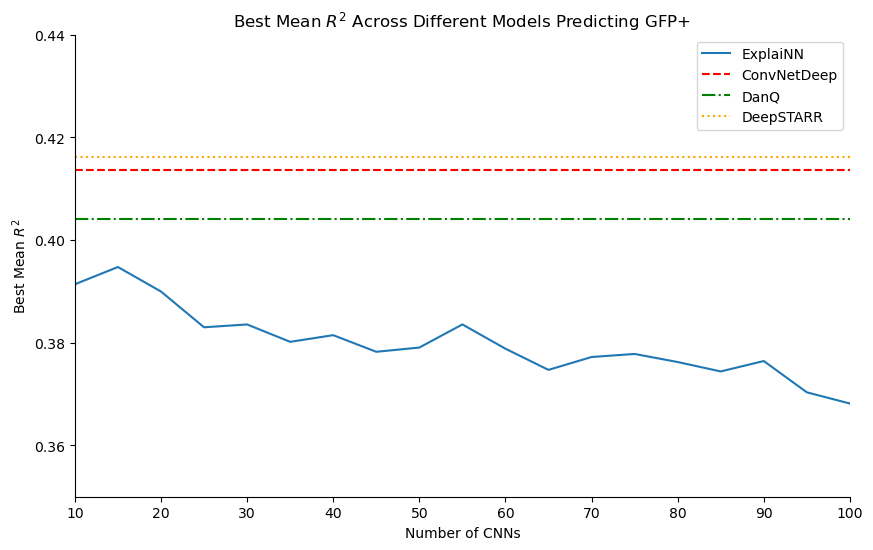

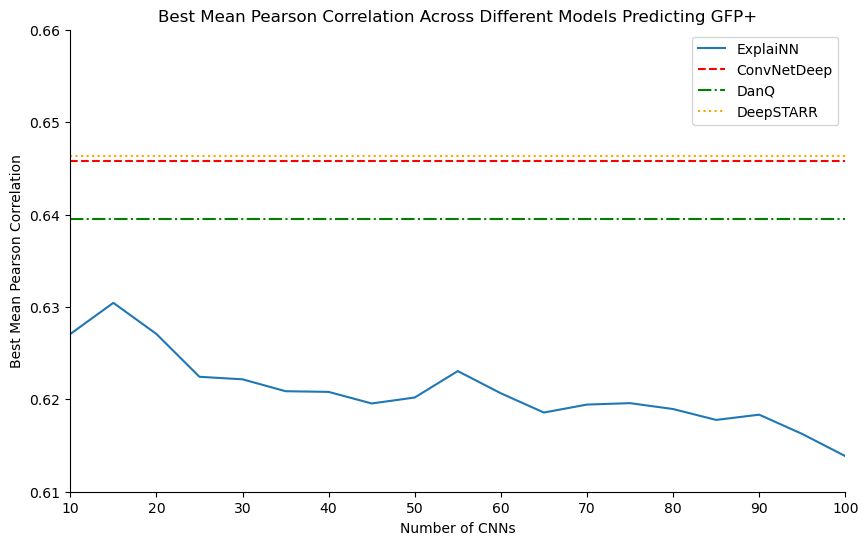

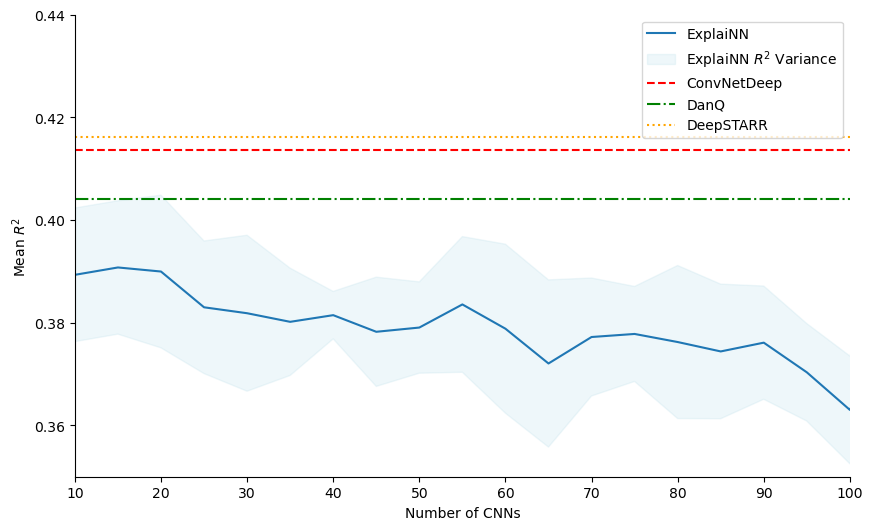

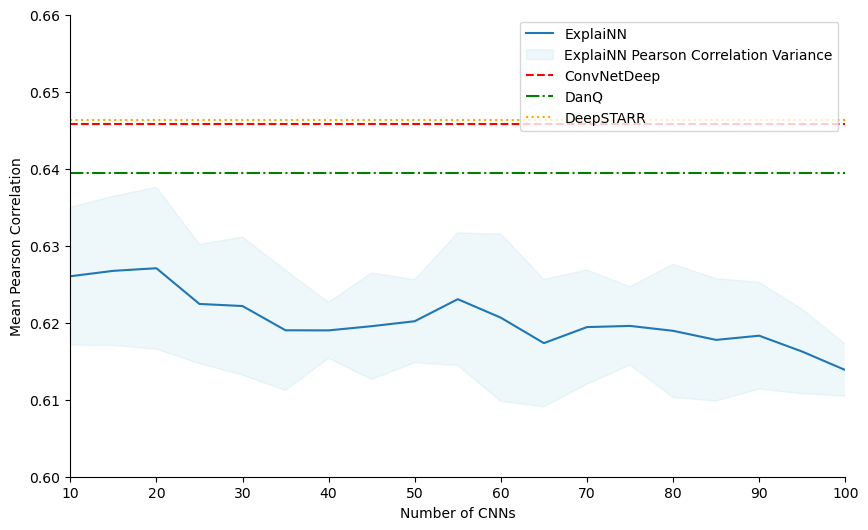

In [18]:
convnet_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ConvNetDeep/ConvNetDeep_GFP_Metrics.csv'
danq_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/DanQ/DanQ_GFP_Metrics.csv'
starr_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR/DeepSTARR_GFP_Metrics.csv'
explainn_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_GFP_Metrics.csv'
visualize_performance(convnet_metric_path, danq_metric_path, starr_metric_path, explainn_metric_path, label='GFP+',xlim=(10,100), r2_ylim=(0.35, 0.44),pearson_ylim=(0.60, 0.66))

# GFP+ & GFP- for merged data

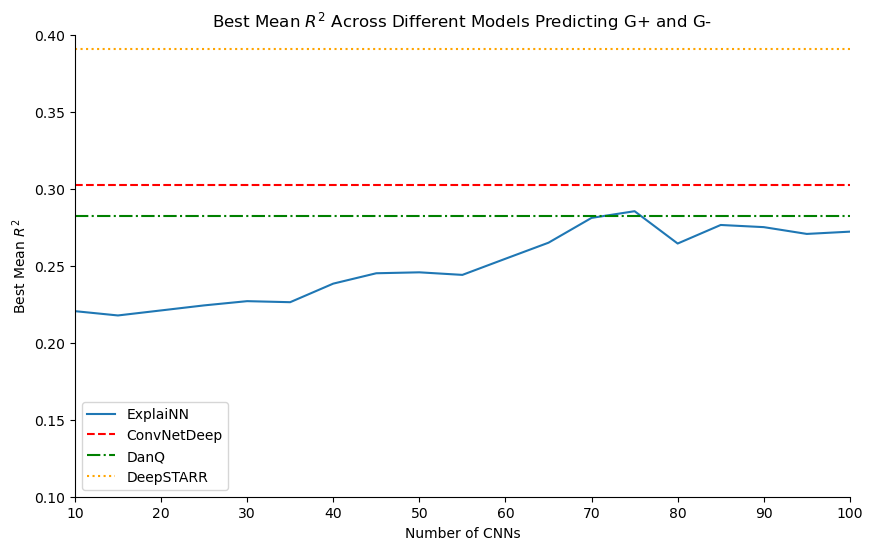

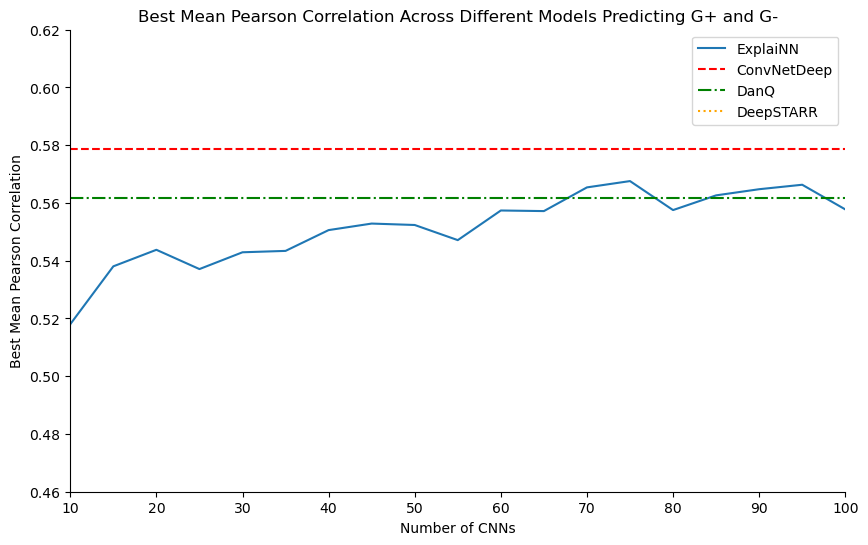

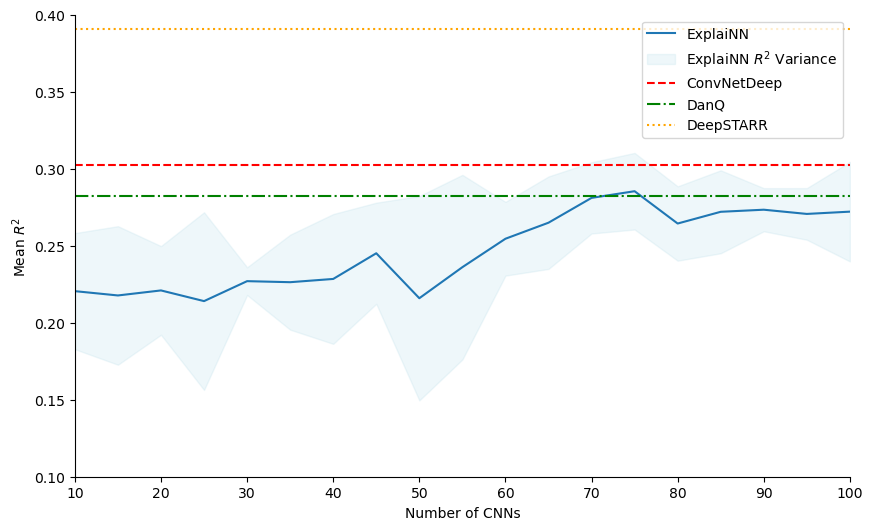

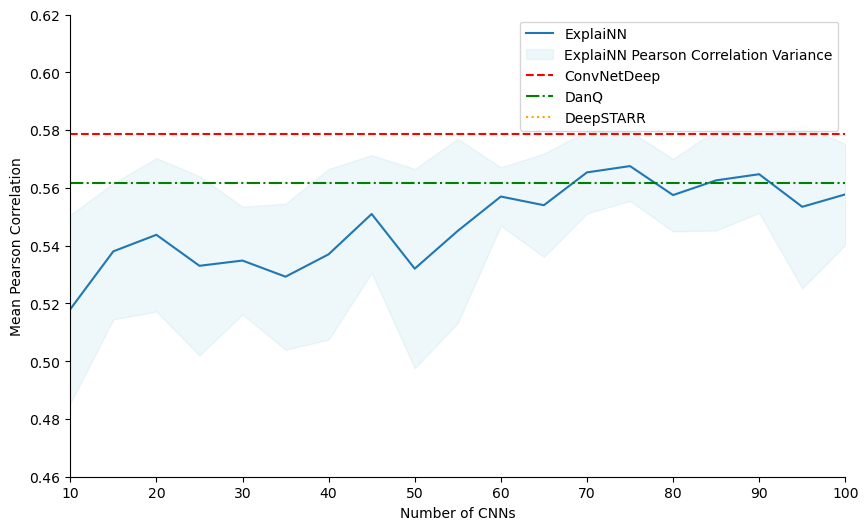

In [ ]:
convnet_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ConvNetDeep/ConvNetDeep_G+G-_Metrics.csv'
danq_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/DanQ/DanQ_G+G-_Metrics.csv'
starr_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR/DeepSTARR_G+G-_Metrics.csv'
explainn_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv'
visualize_performance(convnet_metric_path, danq_metric_path, starr_metric_path, explainn_metric_path, label='G+ and G-',xlim=(10,100), r2_ylim=(0.1, 0.4),pearson_ylim=(0.46, 0.62))

# GFP for Rep1 data

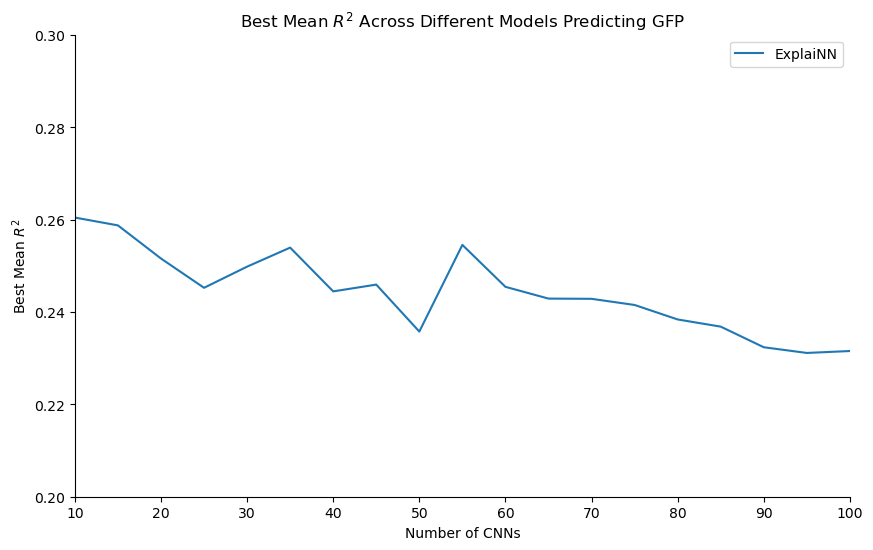

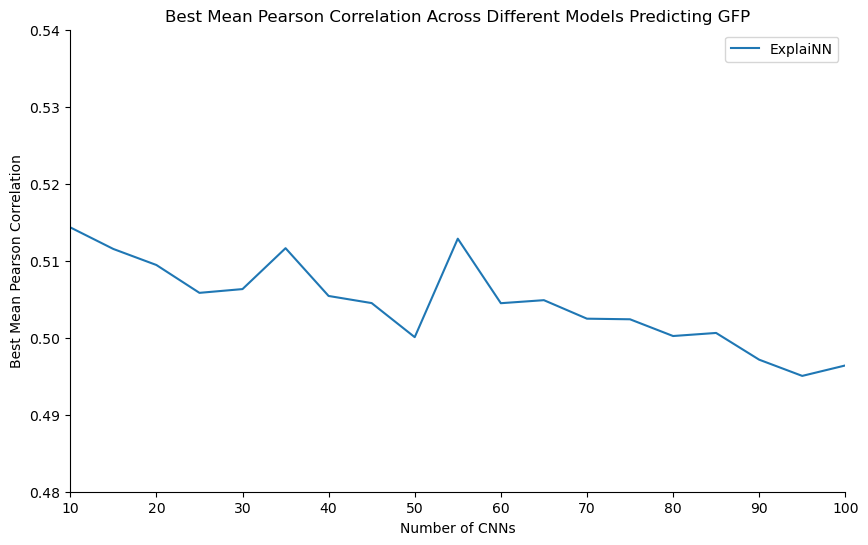

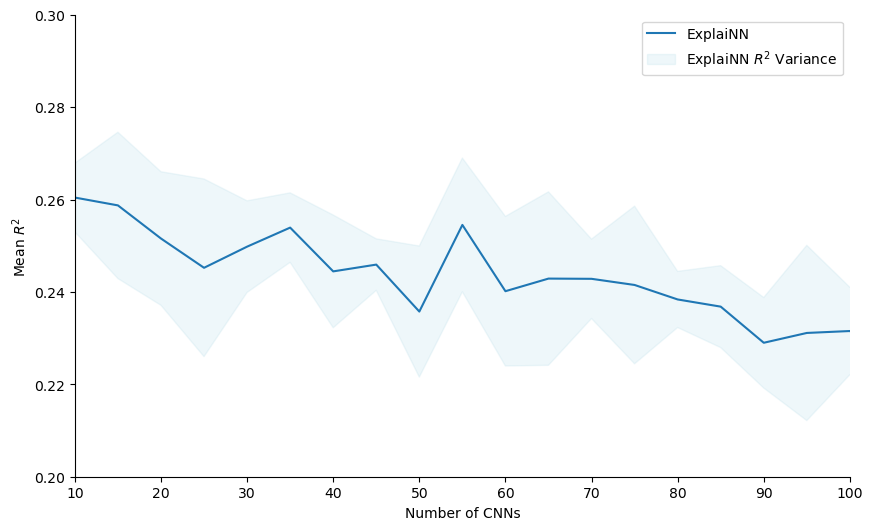

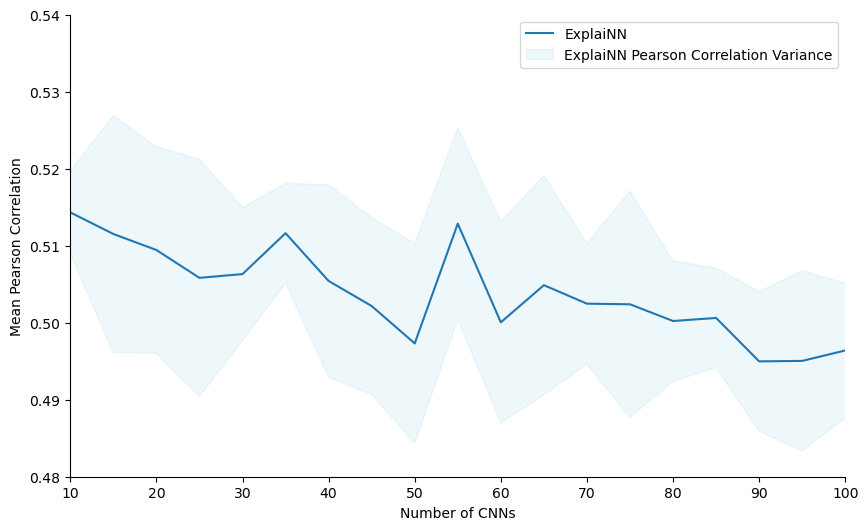

In [31]:
explainn_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_GFP_Rep1_Metrics.csv'
visualize_explainn_performance(explainn_metric_path, label='GFP',xlim=(10,100), r2_ylim=(0.2, 0.3),pearson_ylim=(0.48, 0.54))

# GFP for Rep2 data

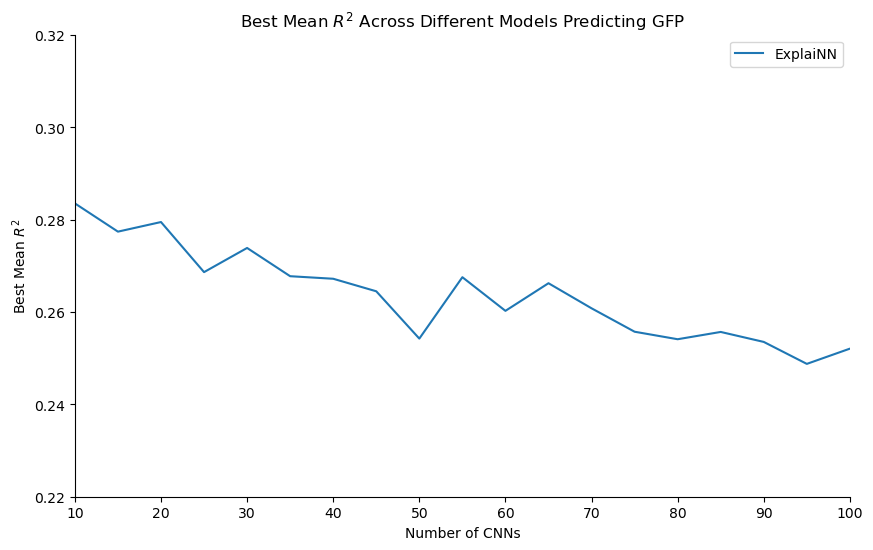

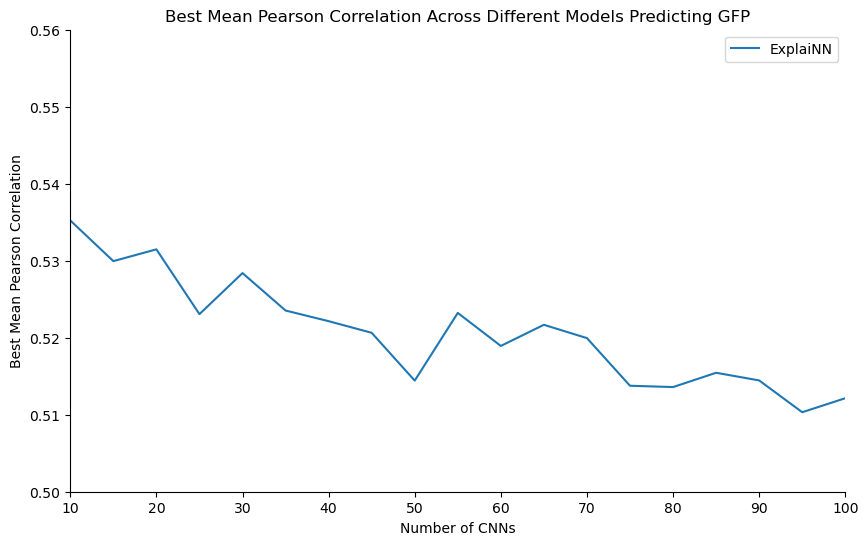

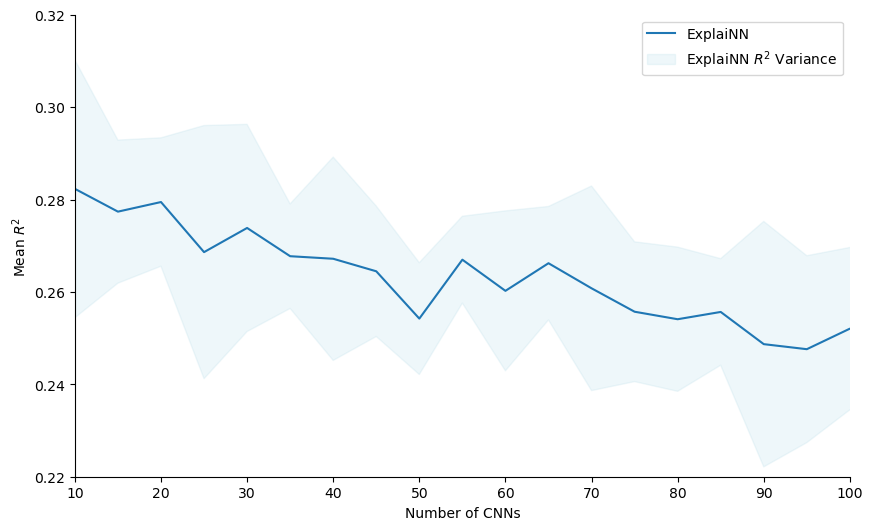

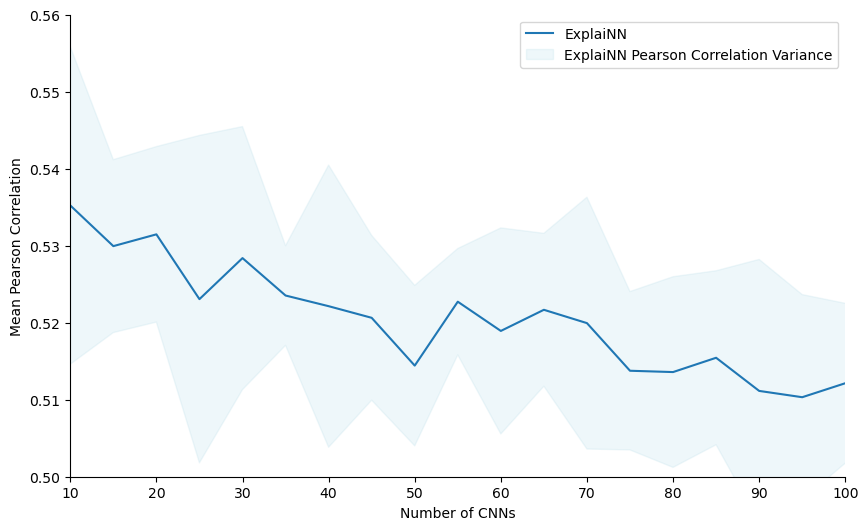

In [32]:
explainn_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_GFP_Rep2_Metrics.csv'
visualize_explainn_performance(explainn_metric_path, label='GFP',xlim=(10,100), r2_ylim=(0.22, 0.32),pearson_ylim=(0.5, 0.56))

# G+ & G- for Rep1 data

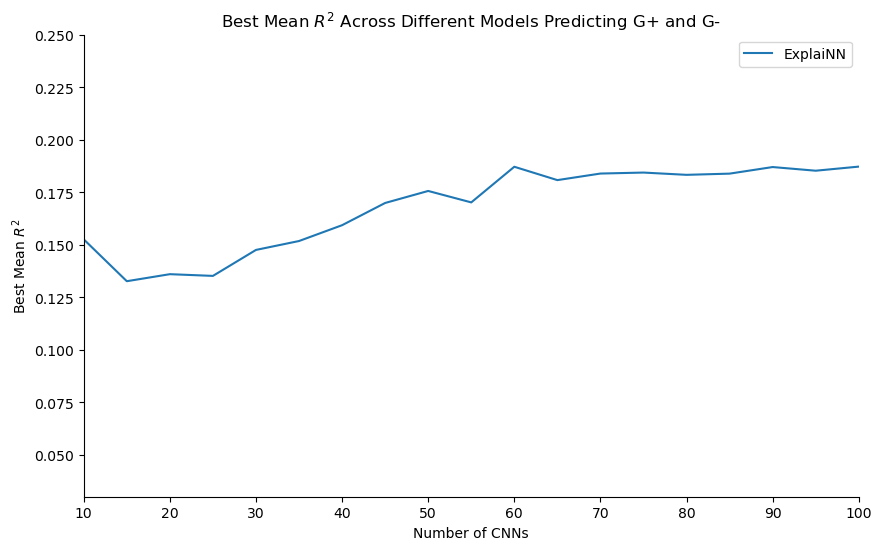

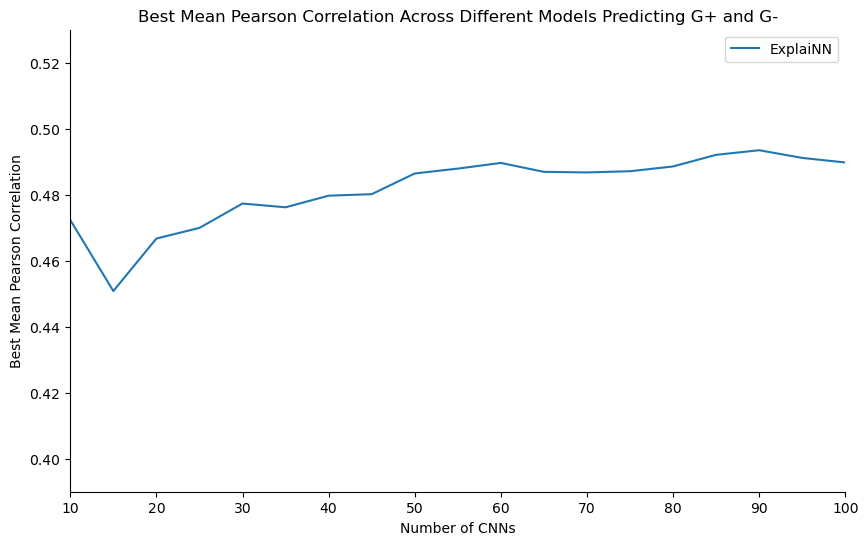

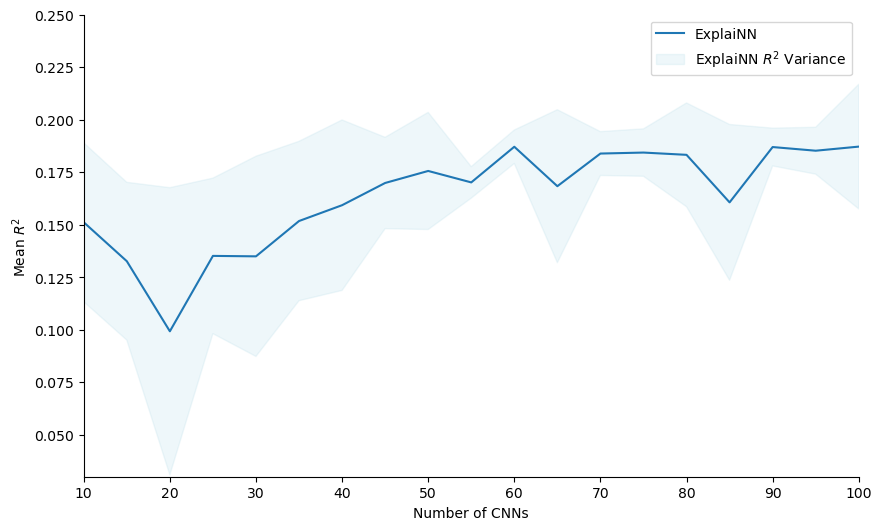

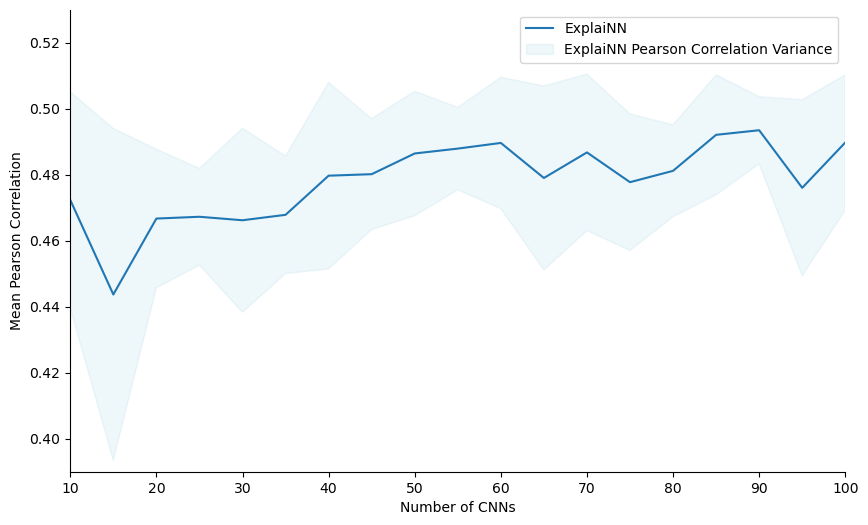

In [37]:
explainn_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Rep1_Metrics.csv'
visualize_explainn_performance(explainn_metric_path, label='G+ and G-',xlim=(10,100), r2_ylim=(0.03, 0.25),pearson_ylim=(0.39, 0.53))

# G+ & G- for Rep2 data

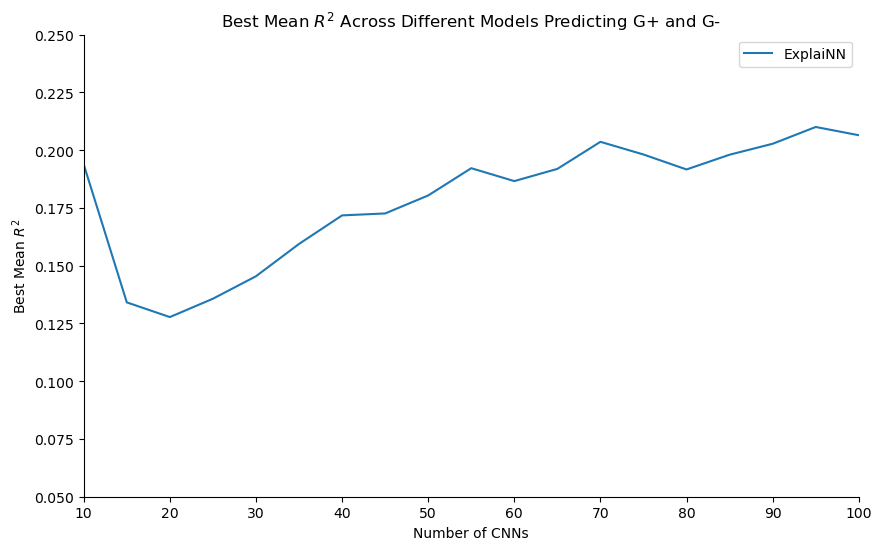

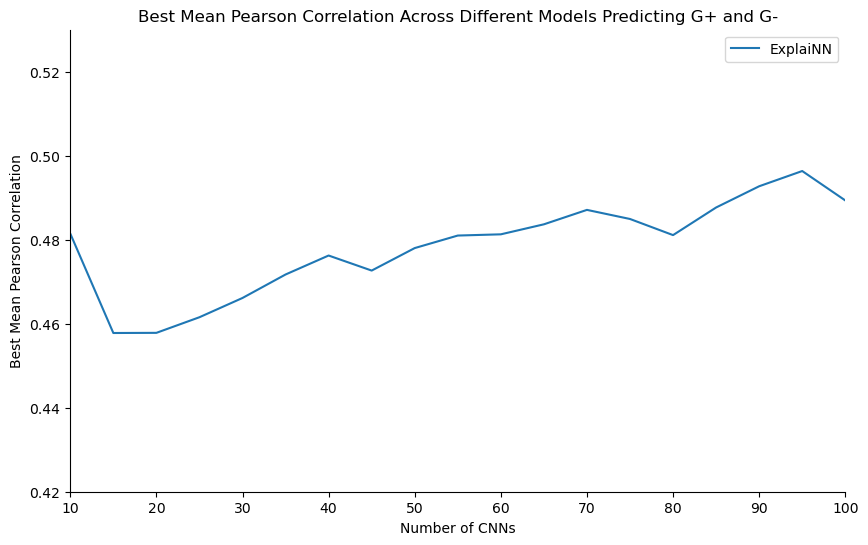

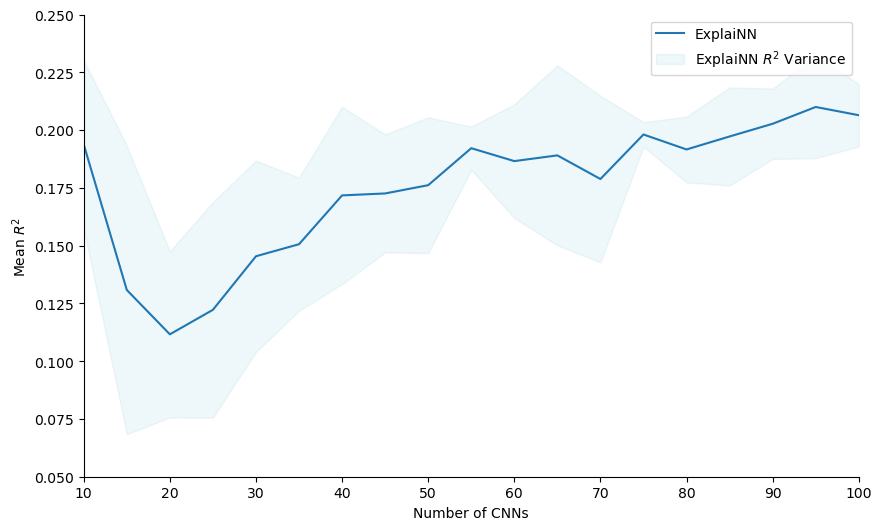

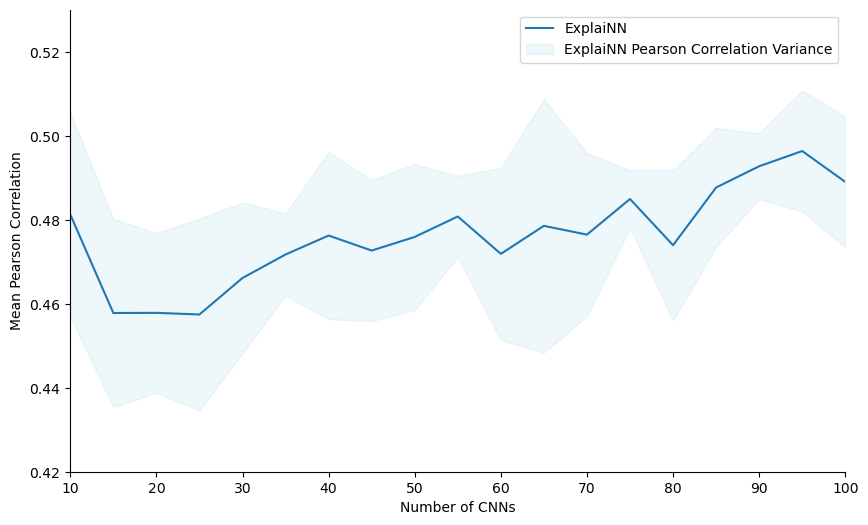

In [41]:
explainn_metric_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Rep2_Metrics.csv'
visualize_explainn_performance(explainn_metric_path, label='G+ and G-',xlim=(10,100), r2_ylim=(0.05, 0.25),pearson_ylim=(0.42, 0.53))